# Analyse et le prétraitement d'images

# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import logging
import tensorflow as tf

# Désactiver une partie des messages d'erreur TF
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
import shutil
from sklearn import preprocessing

# Répertoire contenant les images d'entraînement
data_dir = "./Images3"

# Création du répertoire pour les images de test
test_data_dir = "./Images3_test"
os.makedirs(test_data_dir, exist_ok=True)

# Liste des sous-dossiers (races)
subfolders = os.listdir(data_dir)

# Initialisation des listes pour les chemins des images d'entraînement et de test
path = []
path_test = []

# Parcours de chaque sous-dossier
for subfolder in subfolders:
    # Chemin complet du sous-dossier
    subfolder_path = os.path.join(data_dir, subfolder)
    
    # Création du sous-répertoire de test s'il n'existe pas déjà
    test_subfolder_path = os.path.join(test_data_dir, subfolder)
    if not os.path.exists(test_subfolder_path):
        os.makedirs(test_subfolder_path)
    
    # Chargement des chemins des images dans le sous-dossier
    subfolder_paths = glob(os.path.join(subfolder_path, '*.jpg'))
    
    # Division du sous-dossier en ensembles d'entraînement et de test
    train_paths_sub, test_paths_sub = train_test_split(subfolder_paths, test_size=0.2, random_state=42, stratify=[subfolder]*len(subfolder_paths))
    
    # Déplacement des images de test vers le répertoire de test (si le sous-répertoire est vide)
    if not os.listdir(test_subfolder_path):
        for test_path in test_paths_sub:
            shutil.move(test_path, test_subfolder_path)
    
    # Ajout des chemins d'entraînement et de test aux listes correspondantes
    path.extend(train_paths_sub)
    path_test.extend(test_paths_sub)

# Création des DataFrames pour les données d'entraînement et de test
data = pd.DataFrame({"image_path": path})
data_test = pd.DataFrame({"image_path": path_test})

# Liste des races de chiens dans le Stanford Dogs Dataset
list_labels_dogs = os.listdir(data_dir)

# Fonction pour extraire la race à partir du chemin de l'image
def dog_breed_from_path(photo_path):
    for label in list_labels_dogs:
        if label in photo_path:
            return label.split('-')[-1]
    return "no_breed"

data["label_name"] = data["image_path"].apply(dog_breed_from_path)
data_test["label_name"] = data_test["image_path"].apply(dog_breed_from_path)

# Instanciation de l'encodeur de labels
le = preprocessing.LabelEncoder()

# Adapter l'encodeur de labels aux données d'entraînement
le.fit(data["label_name"])

# Appliquer l'encodeur de labels aux données d'entraînement
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

# Liste nom de chien unique
list_labels = data.label_name.unique()
list_labels_test = data_test.label_name.unique()

# Nombre de race de chien
categ = len(list_labels)
categ_test = len(list_labels_test)

# Liste des labels
label_list = data.label.unique()
label_list_test = data_test.label.unique()

# Affichage des premières lignes des DataFrames
print(data.head())
print(data_test.head())

                                         image_path label_name  label
0  ./Images3\n02085620-Chihuahua\n02085620_4290.jpg  Chihuahua      0
1  ./Images3\n02085620-Chihuahua\n02085620_3880.jpg  Chihuahua      0
2  ./Images3\n02085620-Chihuahua\n02085620_1073.jpg  Chihuahua      0
3  ./Images3\n02085620-Chihuahua\n02085620_2815.jpg  Chihuahua      0
4  ./Images3\n02085620-Chihuahua\n02085620_2937.jpg  Chihuahua      0
                                         image_path label_name  label
0  ./Images3\n02085620-Chihuahua\n02085620_2517.jpg  Chihuahua      0
1  ./Images3\n02085620-Chihuahua\n02085620_2650.jpg  Chihuahua      0
2  ./Images3\n02085620-Chihuahua\n02085620_4159.jpg  Chihuahua      0
3  ./Images3\n02085620-Chihuahua\n02085620_1271.jpg  Chihuahua      0
4  ./Images3\n02085620-Chihuahua\n02085620_2887.jpg  Chihuahua      0


In [3]:
# Affichez les tailles des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(data))
print("Taille de l'ensemble de test :", len(data_test))

# Affichez le nombre unique de races dans chaque ensemble
print("Nombre de races uniques dans l'ensemble d'entraînement :", data["label_name"].nunique())
print("Nombre de races uniques dans l'ensemble de test :", data_test["label_name"].nunique())

# Affichez les premières lignes du DataFrame des données d'entraînement
data.head(5)

Taille de l'ensemble d'entraînement : 192
Taille de l'ensemble de test : 48
Nombre de races uniques dans l'ensemble d'entraînement : 3
Nombre de races uniques dans l'ensemble de test : 3


,image_path,label_name,label
0,./Images3\n02085620-Chihuahua\n02085620_4290.jpg,Chihuahua,0
1,./Images3\n02085620-Chihuahua\n02085620_3880.jpg,Chihuahua,0
2,./Images3\n02085620-Chihuahua\n02085620_1073.jpg,Chihuahua,0
3,./Images3\n02085620-Chihuahua\n02085620_2815.jpg,Chihuahua,0
4,./Images3\n02085620-Chihuahua\n02085620_2937.jpg,Chihuahua,0


In [4]:
data.groupby("label").count()

,image_path,label_name
label,,
0,64,64
1,64,64
2,64,64


list_chihuahua


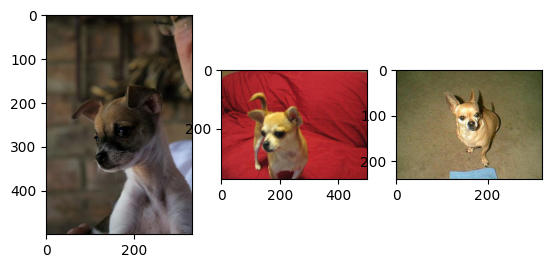

list_golden_retriever


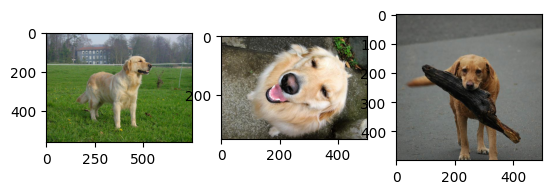

list_french_bulldog


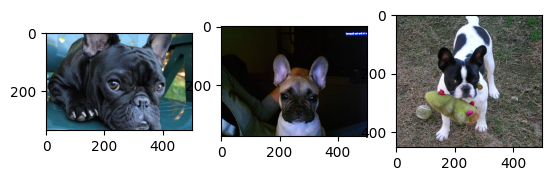

In [5]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

unique_labels = data["label_name"].unique()

for label in unique_labels:
    list_name = f"list_{label.lower().replace(' ', '_')}"
    globals()[list_name] = list_fct(label)

    print(list_name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = globals()[list_name][i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité

# Création du modèle pré-entraîné

In [6]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Création des features des images

In [7]:
images_features = []
i=0
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100


(192, 4096)

# Réduction dimension et analyse
# Réduction de dimension PCA

In [8]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(192, 4096)
(192, 176)


# Réduction de dimension T-SNE et affichage des images selon vraies classes

In [9]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             1.60 secondes


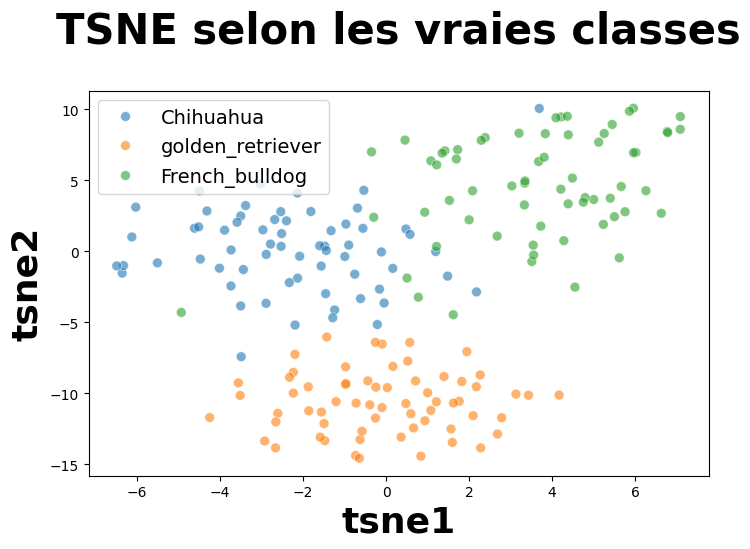

In [10]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=categ), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [11]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=categ, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=3, n_init=100)

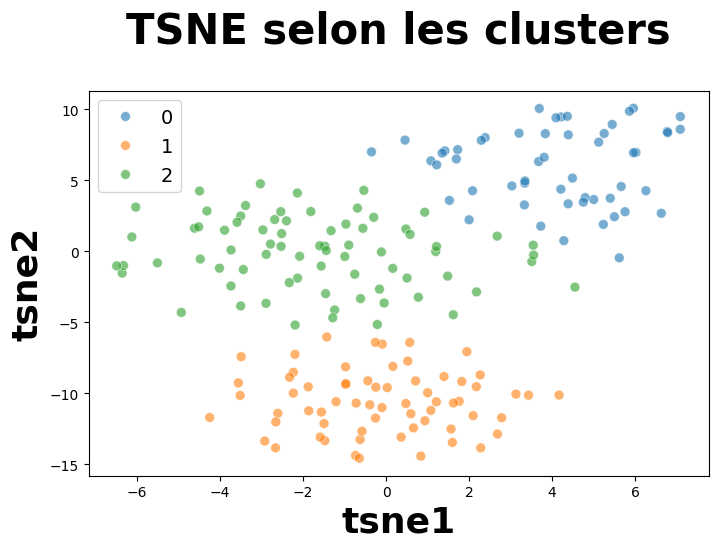

ARI :  0.8024311107082404


In [12]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=categ), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [13]:
# Analyse d'image "chihuahua" affectées au cluster 0 

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Chihuahua') and (df_tsne.iloc[i]['cluster']==0)]
list_shine_0[0]

48

tsne1       3.690893
tsne2       10.06797
class      Chihuahua
cluster            0
Name: 48, dtype: object


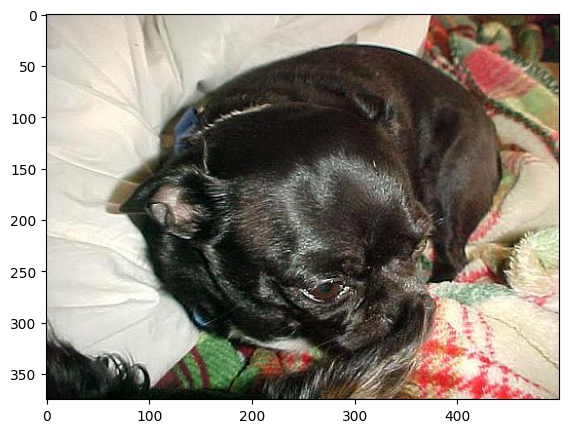

In [14]:
# Affichage image "chihuahua" considérée comme "0"
id = list_shine_0[0] #220
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

* Analyse : le modèle pré-entraîné confond ce chihuahua avec "0" ...

## Approche préparation initiale des images

In [15]:
# Prétraitement des images
def image_prep_fct(data):
    prepared_images = []
    data_reset_index = data.reset_index(drop=True)  # Réinitialiser l'index
    for image_num in range(len(data_reset_index['image_path'])):
        img = (load_img(
            data_reset_index['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)

images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(192, 224, 224, 3)
(48, 224, 224, 3)


In [16]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(144, 224, 224, 3)

In [18]:
import joblib

# Enregistrement des variables importantes pour la première partie
joblib.dump({
    'data': data,
    'data_test': data_test,
    'list_labels': list_labels,
    'categ': categ,
    'label_list': label_list,
    'X_test': X_test,
    'y_test': y_test,
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val
}, 'progression_data1.joblib')

['progression_data1.joblib']